In [1]:
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize

In [2]:
# Read the CSV files into dataframes
misinformation_transcripts_df = pd.read_csv('misinfo_trans_with_punctuation.csv', delimiter=",")
information_transcripts_df = pd.read_csv('info_trans_with_punctuation.csv', delimiter=",")

In [3]:
# function to tokenize text into sentences and then select the first three of those sentences
def get_first_three_sentences(text):
  sentences = sent_tokenize(text)
  first_three_sentences = ' '.join(sentences[:3]) # select the first 3 sentences
  return first_three_sentences

# Apply the function to the transcripts from misinformation_transcripts_df & information_transcripts_df
misinformation_transcripts_df['first_three_sentences'] = misinformation_transcripts_df['transcript_with_punctuation'].apply(get_first_three_sentences)
information_transcripts_df['first_three_sentences'] = information_transcripts_df['transcript_with_punctuation'].apply(get_first_three_sentences)

# Create new dataframes containing only the 'video_id' and 'first_three_sentences' columns
misinfo_first_three_sentences_df = misinformation_transcripts_df[['ID', 'first_three_sentences']]
info_first_three_sentences_df = information_transcripts_df[['ID', 'first_three_sentences']]

In [4]:
from youtube_transcript_api import YouTubeTranscriptApi

def get_first_10_seconds_transcript(video_id):
    try:
        transcript_parts = YouTubeTranscriptApi.get_transcript(video_id)
        first_10_seconds_transcript = ""
        for part in transcript_parts:
            start = part['start']
            if start <= 10:
                first_10_seconds_transcript += part['text'] + ' '
            elif start > 10:
                # If the part starts after 10 seconds, break the loop
                break
        # Check if the transcript is empty (no text found within the first 10 seconds)
        if not first_10_seconds_transcript.strip():
            return ""  # Return an empty string if no text is found
        return first_10_seconds_transcript.strip()  # Return the transcript with leading and trailing whitespace removed
    except Exception as e:
        print(f'Could not get transcript for video {video_id}: {str(e)}')
        return None

In [5]:
# collect ids in array for our YouTube Shorts
mis_video_ids = misinformation_transcripts_df['ID']
info_video_ids = information_transcripts_df['ID']

In [6]:
# Get transcripts for the first 10 seconds of each misinformative short
mis_clickbait_transcripts = []
for video_id in mis_video_ids:
    transcript = get_first_10_seconds_transcript(video_id)
    if transcript:
        mis_clickbait_transcripts.append({'Video ID': video_id, 'Transcript': transcript})

In [7]:
# Get transcripts for the first 10 seconds of each informative short
info_clickbait_transcripts = []
for video_id in info_video_ids:
    transcript = get_first_10_seconds_transcript(video_id)
    if transcript:
        info_clickbait_transcripts.append({'Video ID': video_id, 'Transcript': transcript})

In [8]:
# Convert the list of transcripts to DataFrame
mis_clickbait_transcripts_df = pd.DataFrame(mis_clickbait_transcripts, columns=['Video ID', 'Transcript'])
info_clickbait_transcripts_df = pd.DataFrame(info_clickbait_transcripts, columns=['Video ID', 'Transcript'])

In [9]:
from pytube import YouTube

def get_youtube_short_title(video_id):
    try:
        # Construct the URL for the YouTube short video
        url = f"https://www.youtube.com/shorts/{video_id}"
        # Create a YouTube object
        yt = YouTube(url)
        # Get the video title
        title = yt.title
        return title
    except Exception as e:
        print(f"Error occurred while getting title for video {video_id}: {str(e)}")
        return None

In [10]:
# collect the titles of the informative shorts
info_titles = []
for video_id in info_video_ids:
    title = get_youtube_short_title(video_id)
    if title:
        info_titles.append({'Video ID': video_id, 'Title': title})

# collect the titles of the misinformative shorts
mis_titles = []
for video_id in mis_video_ids:
    title = get_youtube_short_title(video_id)
    if title:
        mis_titles.append({'Video ID': video_id, 'Title': title})

# convert to dataframes
mis_titles_df = pd.DataFrame(mis_titles, columns=['Video ID', 'Title'])
info_titles_df = pd.DataFrame(info_titles, columns=['Video ID', 'Title'])

In [11]:
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [12]:
# Combine dataframes
misinfo_combined_df = pd.concat([misinfo_first_three_sentences_df, mis_clickbait_transcripts_df, mis_titles_df], axis=1)
info_combined_df = pd.concat([info_first_three_sentences_df, info_clickbait_transcripts_df, info_titles_df], axis=1)

# drop unneeded columns
misinfo_combined_df = misinfo_combined_df.drop(columns=['Video ID'])
info_combined_df = info_combined_df.drop(columns=['Video ID'])

# rename columns
misinfo_combined_df = misinfo_combined_df.rename(columns={'ID': 'video_id', 'first_three_sentences': 'three_sentence_transcript', 'Transcript': 'ten_seconds_transcript'})
info_combined_df = info_combined_df.rename(columns={'ID': 'video_id', 'first_three_sentences': 'three_sentence_transcript', 'Transcript': 'ten_seconds_transcript'})

# create a new column called 'three_sentence_transcript' that combines 'title' and 'first_three_seconds'
misinfo_combined_df['title_three_sentences'] = misinfo_combined_df['Title'] + ' ' + misinfo_combined_df['three_sentence_transcript']
info_combined_df['title_three_sentences'] = info_combined_df['Title'] + ' ' + info_combined_df['three_sentence_transcript']

# create a new column called 'title_ten_seconds' that combines 'title' and 'Transcript'
misinfo_combined_df['title_ten_seconds'] = misinfo_combined_df['Title'] + ' ' + misinfo_combined_df['ten_seconds_transcript']
info_combined_df['title_ten_seconds'] = info_combined_df['Title'] + ' ' + info_combined_df['ten_seconds_transcript']

# Select desired columns from misinfo_combined_df
misinfo_selected = misinfo_combined_df[['video_id', 'title_three_sentences', 'title_ten_seconds']]

# Select desired columns from info_combined_df
info_selected = info_combined_df[['video_id', 'title_three_sentences', 'title_ten_seconds']]

In [13]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 640.0 kB/s eta 0:00:20
     --------------------------------------- 0.1/12.8 MB 825.8 kB/s eta 0:00:16
     --------------------------------------- 0.1/12.8 MB 845.5 kB/s eta 0:00:16
     --------------------------------------- 0.2/12.8 MB 919.0 kB/s eta 0:00:14
      --------------------------------------- 0.2/12.8 MB 1.0 MB/s eta 0:00:13
      --------------------------------------- 0.3/12.8 MB 1.0 MB/s eta 0:00:13
      --------------------------------------- 0.3/12.8 MB 1.1 MB/s eta 0:00:12
     - -------------------------------------- 0.4/12.8 MB 1.2 MB/s eta 0:00:11
     - -------------------------------------- 0.5/12.8 MB 1.2 MB/s eta 0:00:11
     - -------------------------------------- 0.6/12.8 MB 1.3 MB/s eta 0:00:10
     -- ------------------------------------- 0.7/12.8 MB 1.4 MB/s eta 0:00:09
     -- ------------------------------------- 0.8/12.8 

c:\Python310\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [14]:
import pandas as pd

# Read the CSV files into dataframes
misinfo_clickbait_combined = pd.read_csv('misinfo_clickbait_combined.csv')
info_clickbait_combined = pd.read_csv('info_clickbait_combined.csv')

In [15]:
import spacy
nlp = spacy.load("en_core_web_trf")

# Define the preprocess_text function
def preprocess_text(text):
    # Check if text is a string or NaN
    if isinstance(text, str):
        # Apply spaCy pipeline
        doc = nlp(text)
        # Tokenize, remove stop words, and lemmatize
        tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
        return ' '.join(tokens)
    else:
        # If text is NaN, return an empty string
        return ''

c:\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Python310\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
c:\Python310\lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [16]:
processed_misinfo_clickbait = misinfo_clickbait_combined['Combined_Text'].apply(preprocess_text)
processed_info_clickbait = info_clickbait_combined['Combined_Text'].apply(preprocess_text)

In [17]:
import numpy as np
import json
import glob

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
from nltk.corpus import stopwords

#vis
import pyLDAvis
import pyLDAvis.gensim

In [18]:
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)

In [19]:
lemmatized_misinfo_clickbait = lemmatization(processed_misinfo_clickbait)
lemmatized_info_clickbait = lemmatization(processed_info_clickbait)

In [20]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

misinfo_data_words = gen_words(lemmatized_misinfo_clickbait)
info_data_words = gen_words(lemmatized_info_clickbait)

In [21]:
#Bigrams and trigrams
import gensim.models

misinfo_bigram_phrases = gensim.models.Phrases(misinfo_data_words, min_count=5, threshold=100)
misinfo_trigram_phrases = gensim.models.Phrases(misinfo_bigram_phrases[misinfo_data_words], threshold=100)

misinfo_bigram = gensim.models.phrases.Phraser(misinfo_bigram_phrases)
misinfo_trigram = gensim.models.phrases.Phraser(misinfo_trigram_phrases)

def make_misinfo_bigrams(texts):
    return([misinfo_bigram[doc] for doc in texts])

def make_misinfo_trigrams(texts):
    return ([misinfo_trigram[misinfo_bigram[doc]] for doc in texts])

misinfo_data_bigrams = make_misinfo_bigrams(misinfo_data_words)
misinfo_data_bigrams_trigrams = make_misinfo_trigrams(misinfo_data_bigrams)



info_bigram_phrases = gensim.models.Phrases(info_data_words, min_count=5, threshold=100)
info_trigram_phrases = gensim.models.Phrases(info_bigram_phrases[info_data_words], threshold=100)

info_bigram = gensim.models.phrases.Phraser(info_bigram_phrases)
info_trigram = gensim.models.phrases.Phraser(info_trigram_phrases)

def make_info_bigrams(texts):
    return([info_bigram[doc] for doc in texts])

def make_info_trigrams(texts):
    return ([info_trigram[info_bigram[doc]] for doc in texts])

info_data_bigrams = make_info_bigrams(info_data_words)
info_data_bigrams_trigrams = make_info_trigrams(info_data_bigrams)

In [22]:
from gensim.models import TfidfModel

info_id2word = corpora.Dictionary(info_data_bigrams_trigrams)

info_texts = info_data_bigrams_trigrams

info_corpus = [info_id2word.doc2bow(text) for text in info_texts]
# print (corpus[0][0:20])

info_tfidf = TfidfModel(info_corpus, id2word=info_id2word)

info_low_value = 0.03
info_words  = []
info_words_missing_in_tfidf = []
for i in range(0, len(info_corpus)):
    info_bow = info_corpus[i]
    info_low_value_words = [] #reinitialize to be safe. You can skip this.
    info_tfidf_ids = [id for id, value in info_tfidf[info_bow]]
    info_bow_ids = [id for id, value in info_bow]
    info_low_value_words = [id for id, value in info_tfidf[info_bow] if value < info_low_value]
    info_drops = info_low_value_words+info_words_missing_in_tfidf
    for item in info_drops:
        info_words.append(info_id2word[item])
    info_words_missing_in_tfidf = [id for id in info_bow_ids if id not in info_tfidf_ids] # The words with tf-idf socre 0 will be missing

    info_new_bow = [b for b in info_bow if b[0] not in info_low_value_words and b[0] not in info_words_missing_in_tfidf]
    info_corpus[i] = info_new_bow

In [60]:
info_lda_model = gensim.models.ldamodel.LdaModel(corpus=info_corpus,
                                           id2word=info_id2word,
                                           num_topics=10,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

In [61]:
pyLDAvis.enable_notebook()
info_vis = pyLDAvis.gensim.prepare(info_lda_model, info_corpus, info_id2word, mds="mmds", R=30)
info_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.215138  0.353929       1        1  21.031472
0      0.132624 -0.363563       2        1  16.778257
5      0.069070  0.333827       3        1  11.282569
3     -0.232611 -0.310118       4        1  10.862170
2     -0.217952  0.101235       5        1  10.073401
9      0.280764  0.196983       6        1   7.898728
1      0.339837 -0.078770       7        1   7.368995
7     -0.294239 -0.072928       8        1   6.952300
6      0.149334 -0.028268       9        1   3.929055
8     -0.011689 -0.132326      10        1   3.823053, topic_info=         Term        Freq       Total Category  logprob  loglift
123    recipe  195.000000  195.000000  Default  30.0000  30.0000
104       add  182.000000  182.000000  Default  29.0000  29.0000
176      food  268.000000  268.000000  Default  28.0000  28.0000
569   cooking   90.000000   90.000000  Default  27.0000  27.0000
2         eat  278.000000  278.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
137     taste    5.628624    9.961313  Topic10  -4.4896   2.6933
511     drink    5.162776   15.709266  Topic10  -4.5760   2.1513
1340     save    4.599426   13.815863  Topic10  -4.6915   2.1642
64        get    5.037972   91.048400  Topic10  -4.6005   0.3697
168     think    3.404733   70.429315  Topic10  -4.9923   0.2347

[441 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1099      7  0.922505     accord
346       4  0.114294   actually
346       5  0.761961   actually
346       7  0.076196   actually
805       6  0.904456         ad
...     ...       ...        ...
174       2  0.960795       work
955      10  0.750294      worth
94        2  0.944859       year
1994      9  0.925092      yeast
1009      8  0.948490  yesterday

[496 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 6, 4, 3, 10, 2, 8, 7, 9])

In [25]:
misinfo_id2word = corpora.Dictionary(misinfo_data_bigrams_trigrams)

misinfo_texts = misinfo_data_bigrams_trigrams

misinfo_corpus = [misinfo_id2word.doc2bow(text) for text in misinfo_texts]
# print (corpus[0][0:20])

misinfo_tfidf = TfidfModel(misinfo_corpus, id2word=misinfo_id2word)

misinfo_low_value = 0.03
misinfo_words  = []
misinfo_words_missing_in_tfidf = []
for i in range(0, len(misinfo_corpus)):
    misinfo_bow = misinfo_corpus[i]
    misinfo_low_value_words = [] #reinitialize to be safe. You can skip this.
    misinfo_tfidf_ids = [id for id, value in misinfo_tfidf[misinfo_bow]]
    misinfo_bow_ids = [id for id, value in misinfo_bow]
    misinfo_low_value_words = [id for id, value in misinfo_tfidf[misinfo_bow] if value < misinfo_low_value]
    misinfo_drops = misinfo_low_value_words+misinfo_words_missing_in_tfidf
    for item in misinfo_drops:
        misinfo_words.append(misinfo_id2word[item])
    misinfo_words_missing_in_tfidf = [id for id in misinfo_bow_ids if id not in misinfo_tfidf_ids] # The words with tf-idf socre 0 will be missing

    misinfo_new_bow = [b for b in misinfo_bow if b[0] not in misinfo_low_value_words and b[0] not in misinfo_words_missing_in_tfidf]
    misinfo_corpus[i] = misinfo_new_bow

In [58]:
misinfo_lda_model = gensim.models.ldamodel.LdaModel(corpus=misinfo_corpus,
                                           id2word=misinfo_id2word,
                                           num_topics=10,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

In [59]:
pyLDAvis.enable_notebook()
misinfo_vis = pyLDAvis.gensim.prepare(misinfo_lda_model, misinfo_corpus, misinfo_id2word, mds="mmds", R=30)
misinfo_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.056291  0.433650       1        1  33.725249
5      0.007643 -0.428910       2        1  14.374779
2     -0.386918 -0.189385       3        1  12.700747
3     -0.271474  0.258171       4        1   8.009172
1      0.252699 -0.227812       5        1   7.161543
0      0.384499  0.007226       6        1   6.623374
9      0.229440  0.262900       7        1   5.735622
4     -0.061679 -0.180870       8        1   5.145124
7     -0.205954  0.020098       9        1   3.987983
6      0.108035  0.044932      10        1   2.536409, topic_info=             Term        Freq       Total Category  logprob  loglift
176           oil  285.000000  285.000000  Default  30.0000  30.0000
28           food  668.000000  668.000000  Default  29.0000  29.0000
15         health  472.000000  472.000000  Default  28.0000  28.0000
276           eat  498.000000  498.000000  Default  27.0000  27.0000
407          base  221.000000  221.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
154       fatigue    3.020379    3.785278  Topic10  -5.1927   3.4487
2410     skincare    2.979711    3.744631  Topic10  -5.2063   3.4459
223        silent    2.855938    3.620793  Topic10  -5.2487   3.4371
814   electrolyte    2.838838    3.603684  Topic10  -5.2547   3.4359
2420     caffeine    5.228990    9.617344  Topic10  -4.6439   3.0651

[376 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
440       7  0.941091  absolutely
1317      8  0.976785     achieve
2790      4  0.959931        acne
578       4  0.962887         add
1370      9  0.910429  affordable
...     ...       ...         ...
686       8  0.901542       white
669       5  0.906014       woman
193       6  0.908017        work
831       4  0.925483     wrinkle
357       3  0.993140        year

[377 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 6, 3, 4, 2, 1, 10, 5, 8, 7])

In [62]:
import pandas as pd

# Extract topic-term distributions for the info_lda_model
info_topic_terms = info_lda_model.print_topics()

# Create a DataFrame to store the results
info_topic_df = pd.DataFrame(columns=['Topic', 'Term', 'Probability'])

# Populate the DataFrame with topic-term distributions
for topic_id, topic in info_topic_terms:
    term_probs = topic.split('+')
    for term_prob in term_probs:
        probability, term = term_prob.split('*')
        term = term.strip().strip('"')
        info_topic_df = info_topic_df.append({'Topic': topic_id, 'Term': term, 'Probability': float(probability)}, ignore_index=True)

# Export DataFrame to CSV
info_topic_df.to_csv('info_lda_topics.csv', index=False)

C:\Users\baerg\AppData\Local\Temp\ipykernel_37748\957573390.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info_topic_df = info_topic_df.append({'Topic': topic_id, 'Term': term, 'Probability': float(probability)}, ignore_index=True)
C:\Users\baerg\AppData\Local\Temp\ipykernel_37748\957573390.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info_topic_df = info_topic_df.append({'Topic': topic_id, 'Term': term, 'Probability': float(probability)}, ignore_index=True)
C:\Users\baerg\AppData\Local\Temp\ipykernel_37748\957573390.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info_topic_df = info_topic_df.append({'Topic': topic_id, 'Term': term, 'Probability': float(probability)}, ignore_index=True)
C:\Users\baerg\A

In [63]:
import pandas as pd

# Extract topic-term distributions for the misinfo_lda_model
misinfo_topic_terms = misinfo_lda_model.print_topics()

# Create a DataFrame to store the results
misinfo_topic_df = pd.DataFrame(columns=['Topic', 'Term', 'Probability'])

# Populate the DataFrame with topic-term distributions
for topic_id, topic in misinfo_topic_terms:
    term_probs = topic.split('+')
    for term_prob in term_probs:
        probability, term = term_prob.split('*')
        term = term.strip().strip('"')
        misinfo_topic_df = misinfo_topic_df.append({'Topic': topic_id, 'Term': term, 'Probability': float(probability)}, ignore_index=True)

# Export DataFrame to CSV
misinfo_topic_df.to_csv('misinfo_lda_topics.csv', index=False)

C:\Users\baerg\AppData\Local\Temp\ipykernel_37748\3620084054.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  misinfo_topic_df = misinfo_topic_df.append({'Topic': topic_id, 'Term': term, 'Probability': float(probability)}, ignore_index=True)
C:\Users\baerg\AppData\Local\Temp\ipykernel_37748\3620084054.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  misinfo_topic_df = misinfo_topic_df.append({'Topic': topic_id, 'Term': term, 'Probability': float(probability)}, ignore_index=True)
C:\Users\baerg\AppData\Local\Temp\ipykernel_37748\3620084054.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  misinfo_topic_df = misinfo_topic_df.append({'Topic': topic_id, 'Term': term, 'Probability': float(probability)}, ignore_index=T

In [65]:
import pandas as pd
from tabulate import tabulate

# Read the CSV files
info_df = pd.read_csv('info_lda_topics.csv')
misinfo_df = pd.read_csv('misinfo_lda_topics.csv')

# Display the merged DataFrame as a table
print(tabulate(info_df, headers='keys', tablefmt='grid'))
print(tabulate(misinfo_df, headers='keys', tablefmt='grid'))

+----+---------+-------------------+---------------+
|    |   Topic | Term              |   Probability |
+====+=========+===================+===============+
|  0 |       0 | eat               |         0.086 |
+----+---------+-------------------+---------------+
|  1 |       0 | know              |         0.05  |
+----+---------+-------------------+---------------+
|  2 |       0 | nutrition         |         0.046 |
+----+---------+-------------------+---------------+
|  3 |       0 | want              |         0.034 |
+----+---------+-------------------+---------------+
|  4 |       0 | bowl              |         0.031 |
+----+---------+-------------------+---------------+
|  5 |       0 | think             |         0.03  |
+----+---------+-------------------+---------------+
|  6 |       0 | powder            |         0.026 |
+----+---------+-------------------+---------------+
|  7 |       0 | dietitian         |         0.024 |
+----+---------+-------------------+----------

C:\Users\baerg\AppData\Local\Temp\ipykernel_37748\1056848157.py:54: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


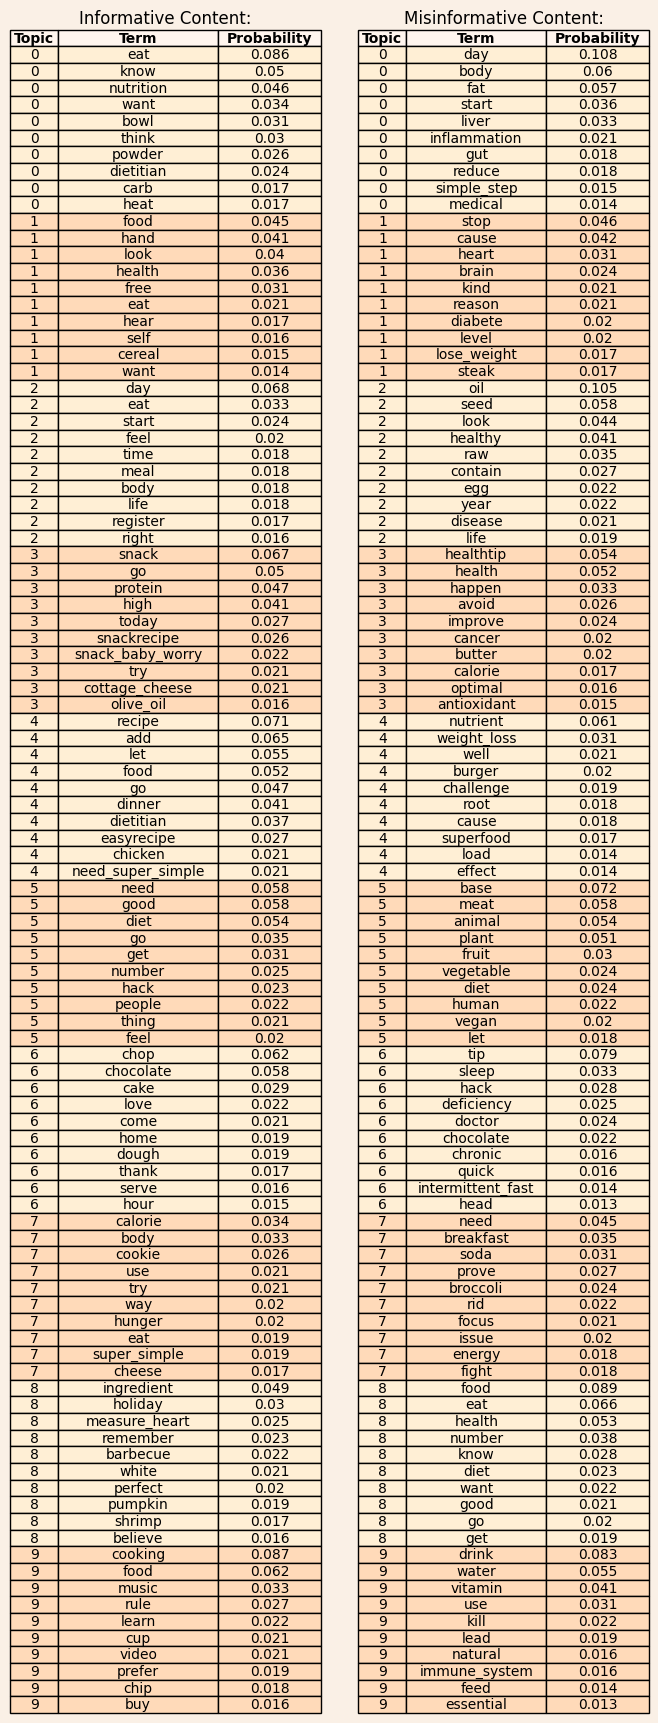

In [147]:
import pandas as pd
import matplotlib.pyplot as plt

# intended title: "\"Clickbait\" Topic Model Probabilities: Titles and Transcripts"

def plot_table(ax, df):
    # Set title based on the DataFrame
    if df.equals(info_df):
        title = "Informative Content:\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n"
    elif df.equals(misinfo_df):
        title = "Misinformative Content:\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n"

    # Add title above the table
    ax.set_title(title, fontsize=12, pad=10)

    # Create and format the table
    ax.axis("off")
    table = ax.table(cellText=df.values,
                     colLabels=df.columns,
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.1] * len(df.columns))

    # Set table properties
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(df.columns))))

    # Change background color of rows based on if topic is  even or odd
    for i, topic in enumerate(df['Topic']):
        if topic % 2 != 1:  # Check if topic number is odd
            for j in range(len(df.columns)):
                table[(i+1, j)].set_facecolor('papayawhip')  # papaya whip background color
        else:
            for j in range(len(df.columns)):
                table[(i+1, j)].set_facecolor('peachpuff')  # peach puff background color

    for j, col_label in enumerate(df.columns):
        table[(0, j)].get_text().set_fontweight('bold')  # Bolden the top row
        table[(0, j)].set_facecolor('seashell')

# Read the CSV files
info_df = pd.read_csv('info_lda_topics.csv')
misinfo_df = pd.read_csv('misinfo_lda_topics.csv')

# Create subplots with adjusted spacing
fig, axes = plt.subplots(1, 2, figsize=(8, 6), facecolor='linen')

# Plot information and misinformation tables
plot_table(axes[0], info_df)
plot_table(axes[1], misinfo_df)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [28]:
# Apply the preprocessing method to selected texts (transcripts and titles)
misinfo_selected['title_three_sentences'] = misinfo_selected['title_three_sentences'].apply(preprocess_text)
misinfo_selected['title_ten_seconds'] = misinfo_selected['title_ten_seconds'].apply(preprocess_text)
info_selected['title_three_sentences'] = info_selected['title_three_sentences'].apply(preprocess_text)
info_selected['title_ten_seconds'] = info_selected['title_ten_seconds'].apply(preprocess_text)

C:\Users\baerg\AppData\Local\Temp\ipykernel_37748\1451176948.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misinfo_selected['title_three_sentences'] = misinfo_selected['title_three_sentences'].apply(preprocess_text)
C:\Users\baerg\AppData\Local\Temp\ipykernel_37748\1451176948.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misinfo_selected['title_ten_seconds'] = misinfo_selected['title_ten_seconds'].apply(preprocess_text)
C:\Users\baerg\AppData\Local\Temp\ipykernel_37748\1451176948.py:4: SettingWi

In [29]:
# Apply lemmatization to the selected texts
misinfo_selected['title_three_sentences'] = lemmatization(misinfo_selected['title_three_sentences'])
misinfo_selected['title_ten_seconds'] = lemmatization(misinfo_selected['title_ten_seconds'])
info_selected['title_three_sentences'] = lemmatization(info_selected['title_three_sentences'])
info_selected['title_ten_seconds'] = lemmatization(info_selected['title_ten_seconds'])

C:\Users\baerg\AppData\Local\Temp\ipykernel_37748\2973259703.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misinfo_selected['title_three_sentences'] = lemmatization(misinfo_selected['title_three_sentences'])
C:\Users\baerg\AppData\Local\Temp\ipykernel_37748\2973259703.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misinfo_selected['title_ten_seconds'] = lemmatization(misinfo_selected['title_ten_seconds'])
C:\Users\baerg\AppData\Local\Temp\ipykernel_37748\2973259703.py:4: SettingWithCopyWarning: 


In [30]:
# Count word frequency for the combined titles with three sentences worth of transcript
mis_word_counts_sentences = Counter(" ".join(misinfo_selected['title_three_sentences']).split())
info_word_counts_sentences = Counter(" ".join(info_selected['title_three_sentences']).split())

# Count word frequency for the combined titles with ten seconds worth of transcript
mis_word_counts_seconds = Counter(" ".join(misinfo_selected['title_ten_seconds']).split())
info_word_counts_seconds = Counter(" ".join(info_selected['title_ten_seconds']).split())

In [31]:
# capture word frequencies for bar charts
misinfo_3s_word_counts = pd.Series(' '.join(misinfo_selected['title_three_sentences']).split()).value_counts()
misinfo_10s_word_counts = pd.Series(' '.join(misinfo_selected['title_ten_seconds']).split()).value_counts()
info_3s_word_counts = pd.Series(' '.join(info_selected['title_three_sentences']).split()).value_counts()
info_10s_word_counts = pd.Series(' '.join(info_selected['title_ten_seconds']).split()).value_counts()

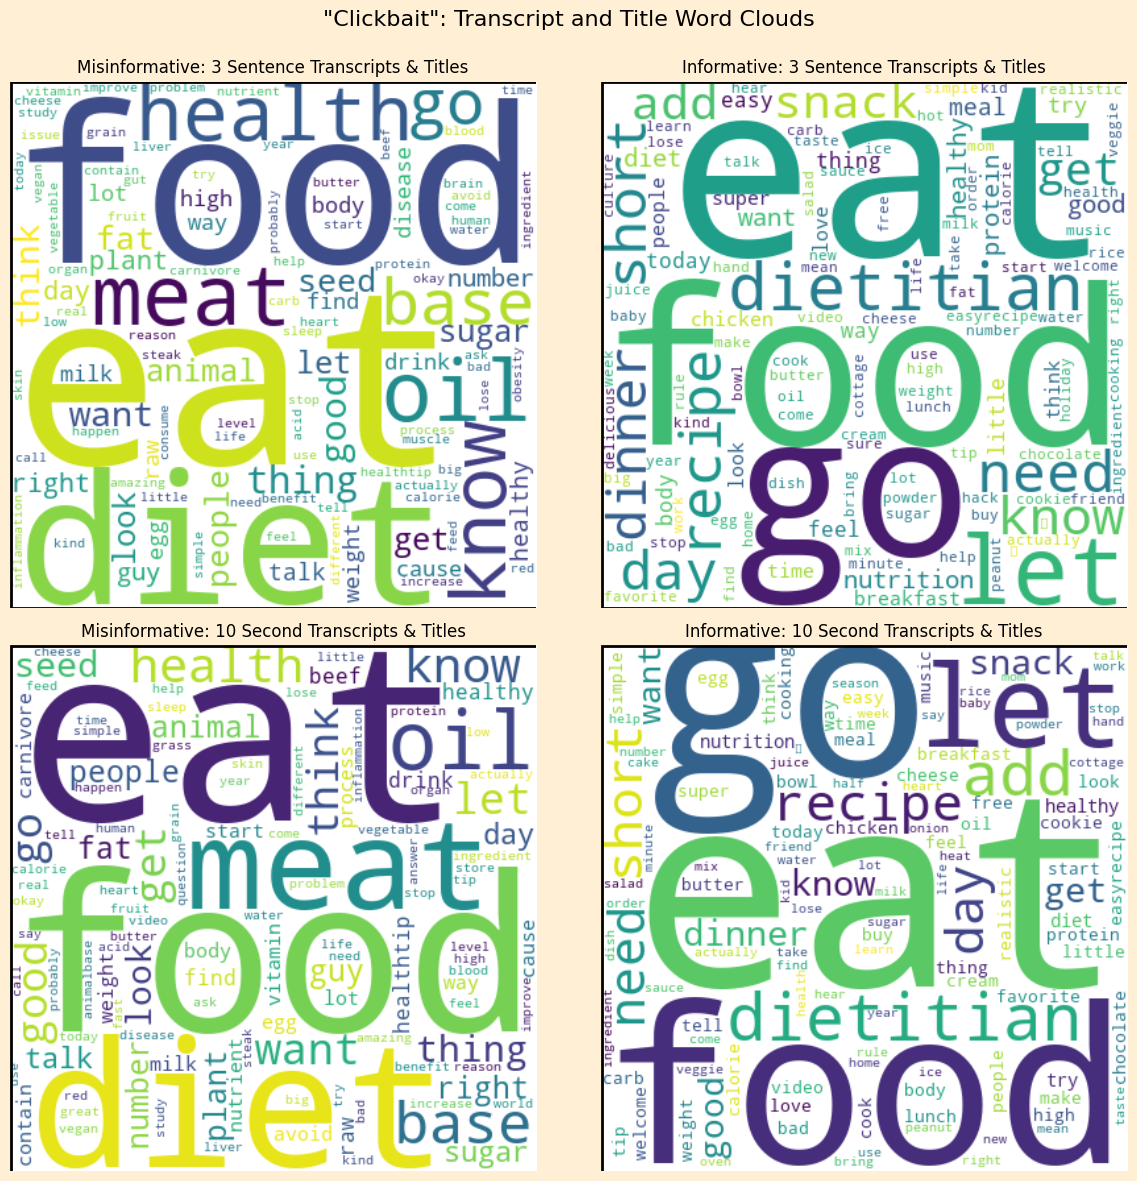

In [52]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Define a function to plot a word cloud with a border
def plot_word_cloud_with_border(word_counts, title):
    wordcloud = WordCloud(width=400, height=400, background_color='white', stopwords=None, min_font_size=10).generate_from_frequencies(word_counts)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.gca().add_artist(plt.Rectangle((0, 0), 400, 400, edgecolor='black', linewidth=2, fill=False))
    plt.axis("off")

    # Add a border

# Create a new figure with a specified background color
plt.figure(figsize=(12, 12), facecolor='papayawhip')  # Change the facecolor parameter to the desired background color

# Add main title above the grid
plt.suptitle("\"Clickbait\": Transcript and Title Word Clouds\n", fontsize=16)

# Plot Misinformative Clickbait: 3 Sentence Transcript + Title
plt.subplot(2, 2, 1)
plot_word_cloud_with_border(mis_word_counts_sentences, "Misinformative: 3 Sentence Transcripts & Titles")

# Plot Informative Clickbait: 3 Sentence Transcript + Title
plt.subplot(2, 2, 2)
plot_word_cloud_with_border(info_word_counts_sentences, "Informative: 3 Sentence Transcripts & Titles")

# Plot Misinformative Clickbait: 10 Second Transcript + Title
plt.subplot(2, 2, 3)
plot_word_cloud_with_border(mis_word_counts_seconds, "Misinformative: 10 Second Transcripts & Titles")

# Plot Informative Clickbait: 10 Second Transcript + Title
plt.subplot(2, 2, 4)
plot_word_cloud_with_border(info_word_counts_seconds, "Informative: 10 Second Transcripts & Titles")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

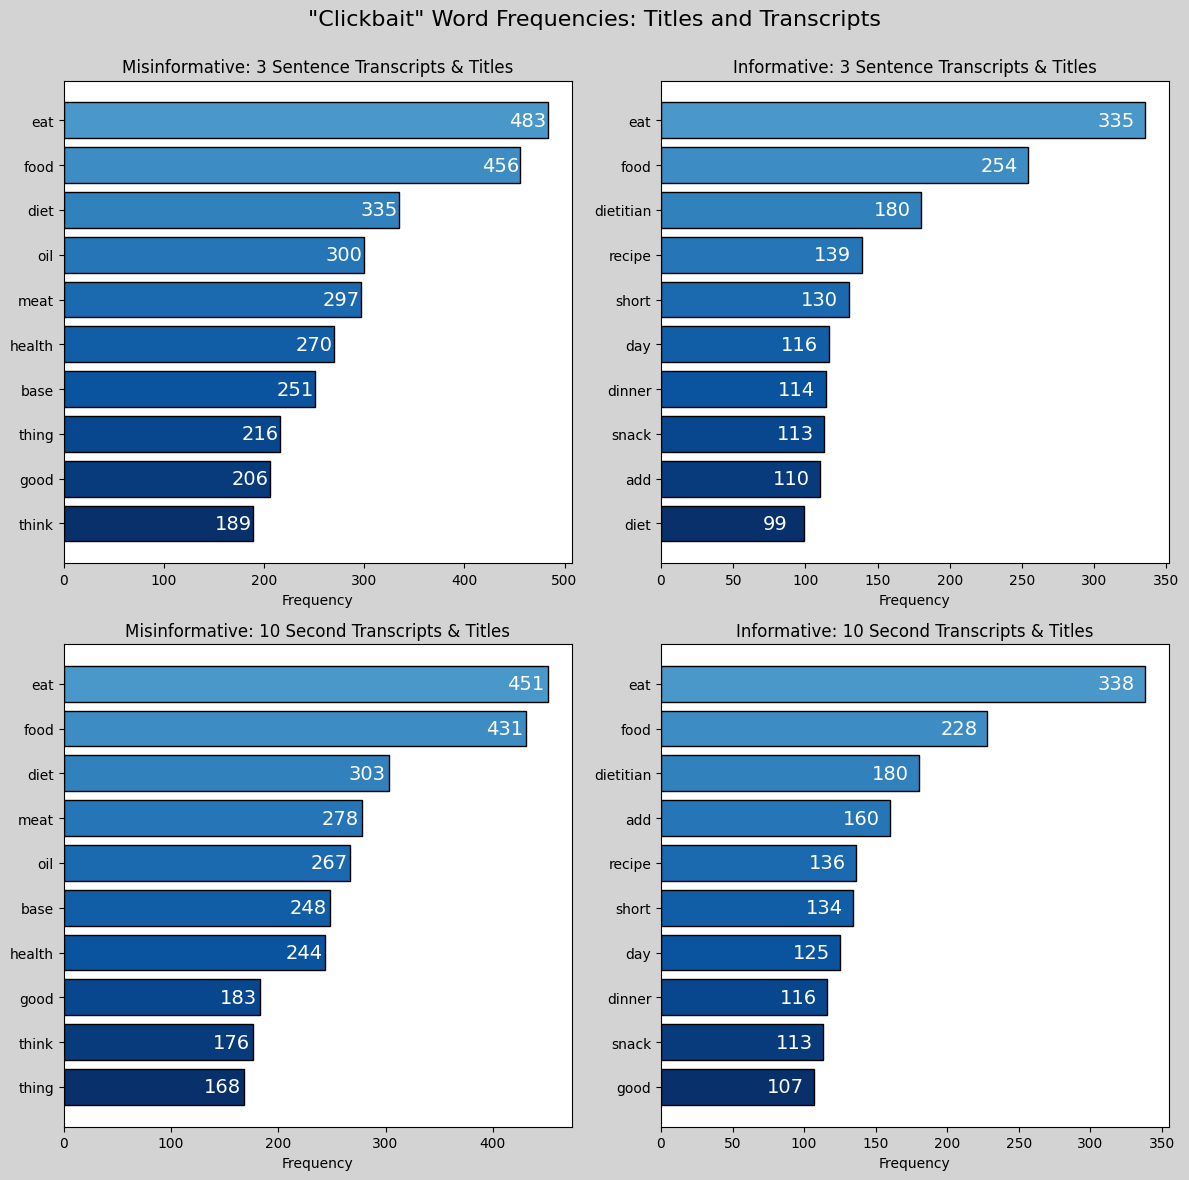

In [57]:
import matplotlib.pyplot as plt
import numpy as np  # Import numpy for generating colors

stop_words = ["go", "im", "one", "let", "get", "like", "youre", "know", "want", "need"]
# Define a function to plot a bar chart with black borders around bars
def plot_bar_chart(word_counts, title):
    # Filter out stop words from word_counts
    word_counts_filtered = word_counts[~word_counts.index.isin(stop_words)]

    # Take the top ten most frequent words after filtering
    word_counts_top_ten = word_counts_filtered.head(10)

    # Generate 10 different shades of sky blue
    skyblue_colors = plt.get_cmap('Blues')(np.linspace(0.6, 1, 10))

    bars = plt.barh(word_counts_top_ten.index, word_counts_top_ten.values, color=skyblue_colors)
    for bar in bars:
        bar.set_edgecolor('black')  # Set black border color for each bar
        width = bar.get_width()
        plt.text(width - 20, bar.get_y() + bar.get_height()/2, f'{int(width)}', ha='center', va='center', color='white', fontsize=14)  # Add count on the right side with padding
    plt.gca().invert_yaxis()  # Invert y-axis to have the most frequent words at the top
    plt.title(title)
    plt.xlabel('Frequency')



# Create a new figure
plt.figure(figsize=(12, 12), facecolor='lightgrey')

# Add main title above the grid
plt.suptitle("\"Clickbait\" Word Frequencies: Titles and Transcripts\n", fontsize=16)

# Plot Misinformative Clickbait: 3 Sentence Transcript + Title
plt.subplot(2, 2, 1)
plot_bar_chart(misinfo_3s_word_counts, "Misinformative: 3 Sentence Transcripts & Titles")

# Plot Informative Clickbait: 3 Sentence Transcript + Title
plt.subplot(2, 2, 2)
plot_bar_chart(info_3s_word_counts, "Informative: 3 Sentence Transcripts & Titles")

# Plot Misinformative Clickbait: 10 Second Transcript + Title
plt.subplot(2, 2, 3)
plot_bar_chart(misinfo_10s_word_counts, "Misinformative: 10 Second Transcripts & Titles")

# Plot Informative Clickbait: 10 Second Transcript + Title
plt.subplot(2, 2, 4)
plot_bar_chart(info_10s_word_counts, "Informative: 10 Second Transcripts & Titles")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()